# Multi-stage cyclic symmetry using advanced customization {#ref_multi_stage_cyclic_advanced}

This example shows how to expand on selected sectors the mesh and
results from a multi-stage cyclic analysis. It also shows how to use the
cyclic support for advanced postprocessing


In [1]:
from ansys.dpf import core as dpf
from ansys.dpf.core import examples
from ansys.dpf.core import operators as ops

Create the model and display the state of the result.


In [2]:
cyc = examples.download_multi_stage_cyclic_result()
model = dpf.Model(cyc)
print(model)

DPF Model
------------------------------
Modal analysis
Unit system: MKS: m, kg, N, s, V, A, degC
Physics Type: Mechanical
Available results:
     -  displacement: Nodal Displacement
     -  stress: ElementalNodal Stress 
     -  elastic_strain: ElementalNodal Strain
     -  structural_temperature: ElementalNodal Temperature
------------------------------
DPF  Meshed Region: 
  3595 nodes 
  1557 elements 
  Unit: m 
  With solid (3D) elements
------------------------------
DPF  Time/Freq Support: 
  Number of sets: 6 
Cumulative     Frequency (Hz) LoadStep       Substep        Harmonic index  
1              188.385357     1              1              0.000000        
2              325.126418     1              2              0.000000        
3              595.320548     1              3              0.000000        
4              638.189511     1              4              0.000000        
5              775.669703     1              5              0.000000        
6            

Check the result info to verify that it\'s a multi-stage model


In [3]:
result_info = model.metadata.result_info
print(result_info.has_cyclic)
print(result_info.cyclic_symmetry_type)

True
multi_stage


Go over the cyclic support


In [4]:
cyc_support = result_info.cyclic_support
print("num stages:", cyc_support.num_stages)
print("num_sectors stage 0:", cyc_support.num_sectors(0))
print("num_sectors stage 1:", cyc_support.num_sectors(1))
print(
    "num nodes in the first stage's base sector: ",
    len(cyc_support.base_nodes_scoping(0)),
)

num stages: 2
num_sectors stage 0: 6
num_sectors stage 1: 12
num nodes in the first stage's base sector:  2220


# Expand displacement results

This example expands displacement results on chosen sectors.


In [5]:
# Create displacement cyclic operator
UCyc = dpf.operators.result.cyclic_expanded_displacement()
UCyc.inputs.data_sources(model.metadata.data_sources)
# Select the sectors to expand on the first stage
UCyc.inputs.sectors_to_expand([0, 1, 2])
# Or select the sectors to expand stage by stage
sectors_scopings = dpf.ScopingsContainer()
sectors_scopings.labels = ["stage"]
sectors_scopings.add_scoping({"stage": 0}, dpf.Scoping(ids=[0, 1, 2]))
sectors_scopings.add_scoping({"stage": 1}, dpf.Scoping(ids=[0, 1, 2, 3, 4, 5, 6]))
UCyc.inputs.sectors_to_expand(sectors_scopings)

# expand the displacements and get a total deformation
nrm = dpf.Operator("norm_fc")
nrm.inputs.connect(UCyc.outputs)
fields = nrm.outputs.fields_container()

# # get the expanded mesh
mesh_provider = model.metadata.mesh_provider
mesh_provider.inputs.read_cyclic(2)
mesh = mesh_provider.outputs.mesh()

# Plot the expanded result on the expanded mesh


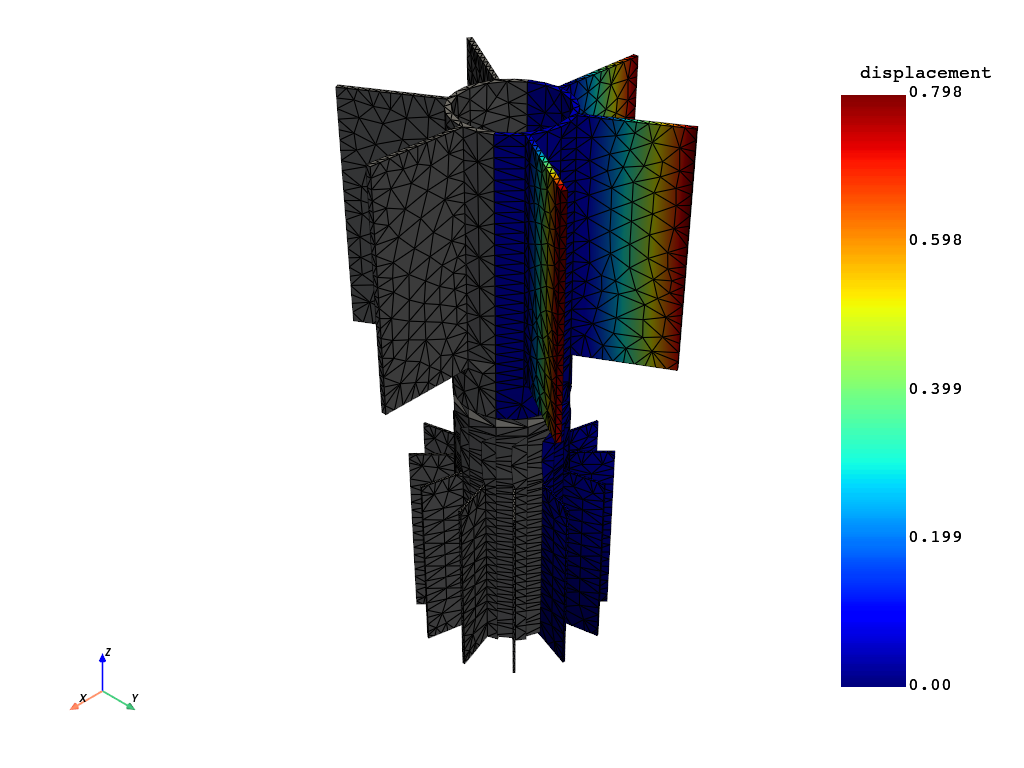

In [6]:
mesh.plot(fields)

# Choose to expand only some sectors for the mesh


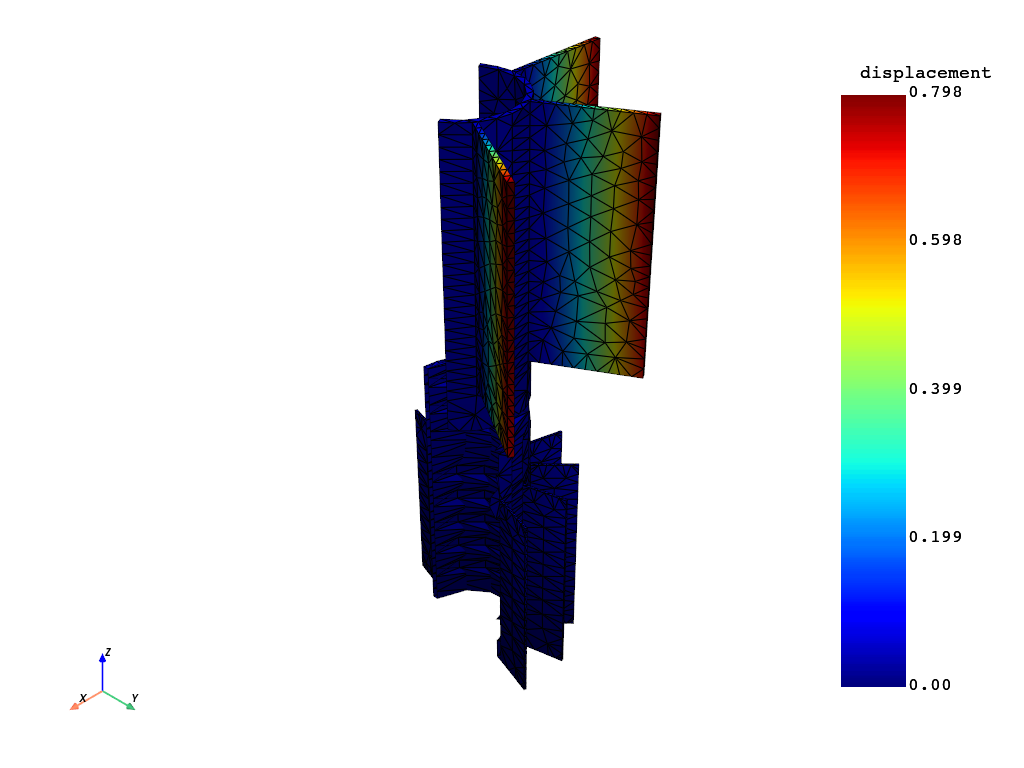

In [7]:
cyc_support_provider = ops.metadata.cyclic_support_provider(
    data_sources=model.metadata.data_sources
)
cyc_support_provider.inputs.sectors_to_expand(sectors_scopings)
mesh_exp = ops.metadata.cyclic_mesh_expansion(cyclic_support=cyc_support_provider)
selected_sectors_mesh = mesh_exp.outputs.meshed_region()

# # plot the expanded result on the expanded mesh
selected_sectors_mesh.plot(fields)

# Check results precisely


In [8]:
# Print the time_freq_support to see the harmonic index
print(model.metadata.time_freq_support)
print(model.metadata.time_freq_support.get_harmonic_indices(stage_num=1).data)

# Harmonic index 0 means that the results are symmetric sectors by sector
# taking a node in the base sector of the first stage
node_id = cyc_support.base_nodes_scoping(0)[18]
print(node_id)

# Check what are the expanded ids of this node
expanded_ids = cyc_support.expand_node_id(node_id, [0, 1, 2], 0)
print(expanded_ids.ids)

# Verify that the displacement values are the same on all those nodes
for node in expanded_ids.ids:
    print(fields[0].get_entity_data_by_id(node))

DPF  Time/Freq Support: 
  Number of sets: 6 
Cumulative     Frequency (Hz) LoadStep       Substep        Harmonic index  
1              188.385357     1              1              0.000000        
2              325.126418     1              2              0.000000        
3              595.320548     1              3              0.000000        
4              638.189511     1              4              0.000000        
5              775.669703     1              5              0.000000        
6              928.278013     1              6              0.000000        

[0. 0. 0. 0. 0. 0.]
1394
[1394 4989 7209]
[0.07179672]
[0.07179672]
[0.07179672]
